# Part 5: RAG with Vertex Search

## Install required libraries

We will first need to install and upgrade the Google Cloud Discovery Engine library.

Once the library is installed, restart the kernel so that you can use the updated packages

In [2]:
!pip install --upgrade google-cloud-discoveryengine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.7 MB/s eta 0:00:00a 0:00:010m
  Attempting uninstall: google-cloud-discoveryengine
    Found existing installation: google-cloud-discoveryengine 0.11.7
    Uninstalling google-cloud-discoveryengine-0.11.7:
      Successfully uninstalled google-cloud-discoveryengine-0.11.7


## Import libraries and set variables

In [3]:
from typing import Optional

from google.api_core.client_options import ClientOptions
from google.cloud import discoveryengine

from google.cloud import discoveryengine_v1alpha as discoveryengine
from google.api_core.client_options import ClientOptions

In [15]:
# Set the Project ID
PROJECT_IDS = !(gcloud config get-value core/project)
project_id = PROJECT_IDS[0]
GCP_PROJECT = PROJECT_ID = project_id #= "<REPLACE_PROJECT_ID>"

# # Set the location
LOCATION = location = "global"

MIME_TYPE = mime_type = "application/pdf"

GCS_BUCKET_LOCATION = "asia-southeast1"
REGION = 'asia-southeast1'

PREFIX = project_id #"<REPLACE_WITH_YOUR_NAME>"

GCS_BUCKET_NAME = f"p5-hp-books-{PREFIX}"
GCS_BUCKET_URI = f"gs://{GCS_BUCKET_NAME}"


Creating gs://p5-hp-books-my-project-0004-346516/...
ServiceException: 409 A Cloud Storage bucket named 'p5-hp-books-my-project-0004-346516' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


## Configure Datastore

### Upload the book PDFs onto Google Cloud Storage (GCS) bucket

In [16]:
# Create a Cloud Storage Bucket
!gcloud storage buckets create $GCS_BUCKET_URI --location=$GCS_BUCKET_LOCATION

Creating gs://p5-hp-books-my-project-0004-346516/...
ERROR: (gcloud.storage.buckets.create) HTTPError 409: The requested bucket name is not available. The bucket namespace is shared by all users of the system. Please select a different name and try again.


In [17]:
# Upload the PDFs located in the books/ directory into the GCS bucket that you created
!gsutil cp -r ./books/* $GCS_BUCKET_URI

Copying file://./books/Book1_HarryPotter_and_the_Sorcerers_Stone_pg15.pdf [Content-Type=application/pdf]...
Copying file://./books/Book1_The_Sorcerers_Stone.pdf [Content-Type=application/pdf]...
Copying file://./books/Book2_The_Chamber_of_Secrets.pdf [Content-Type=application/pdf]...
Copying file://./books/Book3_The_Prisoner_of_Azkaban.pdf [Content-Type=application/pdf]...
- [4 files][  4.0 MiB/  4.0 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying file://./books/Book4_The_Goblet_of_Fire.pdf [Content-Type=application/pdf]...
Copying file://./books/Book5_The_Order_of_the_Phoenix.pdf [Content-Type=application/pdf]...
Copying file://./books/Book6_The_HalfBlood_Prince.pdf [Content-Type=application/pdf]...
Copying file://./books/Bo

In [18]:
# Verify that all Books 1 to 7 are uploaded to the GCS bucket (8 files in total, 2 for Part 1)
!gsutil ls $GCS_BUCKET_URI

gs://p5-hp-books-my-project-0004-346516/Book1_HarryPotter_and_the_Sorcerers_Stone_pg15.pdf
gs://p5-hp-books-my-project-0004-346516/Book1_The_Sorcerers_Stone.pdf
gs://p5-hp-books-my-project-0004-346516/Book2_The_Chamber_of_Secrets.pdf
gs://p5-hp-books-my-project-0004-346516/Book3_The_Prisoner_of_Azkaban.pdf
gs://p5-hp-books-my-project-0004-346516/Book4_The_Goblet_of_Fire.pdf
gs://p5-hp-books-my-project-0004-346516/Book5_The_Order_of_the_Phoenix.pdf
gs://p5-hp-books-my-project-0004-346516/Book6_The_HalfBlood_Prince.pdf
gs://p5-hp-books-my-project-0004-346516/Book7_The_Deathly_Hallows.pdf


### Setup Gemini Pro (Helper Functions)

In [19]:
import os
import vertexai
from vertexai.preview.language_models import TextGenerationModel

LOCATION = REGION = 'us-central1'

vertexai.init(project=PROJECT_ID, location=REGION)

# @st.cache_resource
def get_model():
    generation_model = TextGenerationModel.from_pretrained("text-bison@002")
    return generation_model


def get_text_generation(prompt="", **parameters):
    generation_model = get_model()
    response = generation_model.predict(prompt=prompt, **parameters)

    return response.text

import vertexai
from vertexai.language_models import TextGenerationModel

vertexai.init(project=PROJECT_ID, location=LOCATION)
parameters = {
    "candidate_count": 1,
    "max_output_tokens": 1024,
    "temperature": 1,
    "top_k": 40
}

def generate_palm_unicorn_v1(input_prompt):
    
    model = TextGenerationModel.from_pretrained("text-unicorn@001")

    response = model.predict(
        input_prompt,
        **parameters
    )
    print(f"Response from Model: {response.text}")
    
    return(response.text)

def generate_palm_bison32k(input_prompt):
    
    model = TextGenerationModel.from_pretrained("text-bison-32k")

    response = model.predict(
        input_prompt,
        **parameters
    )
    print(f"Response from Model: {response.text}")
    
    return(response.text)

import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part

# input_prompt = """can you give me details of paracetamol"""

def generate(input_prompt):
    model = GenerativeModel("gemini-ultra")
    responses = model.generate_content(
        input_prompt ,
    generation_config={
        "max_output_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1,
        "top_k": 32
    },
        safety_settings=[],
        stream=True,
    )
    
    all_response  = []
    
    for response in responses:
        # print(response.text, end="")
        all_response.append(response.text)
    
    # print (all_response)
    
    return(" ".join(all_response))
    

def generate_pro(input_prompt):
    model = GenerativeModel("gemini-pro")
    responses = model.generate_content(
    input_prompt,
    generation_config={
        "max_output_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1
    },stream=True,)
    
    all_response  = []
    
    for response in responses:
        all_response.append(response.text)
    
    # print (all_response)
    
    return(" ".join(all_response))

### Create an empty datastore

In [20]:
# Helper Function to create data store
def create_data_store(
    project_id: str, location: str, data_store_name: str, data_store_id: str
):
    # Create a client
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    client = discoveryengine.DataStoreServiceClient(client_options=client_options)

    # Initialize request argument(s)
    data_store = discoveryengine.DataStore(
        display_name=data_store_name,
        industry_vertical="GENERIC",
        content_config="CONTENT_REQUIRED",
    )

    request = discoveryengine.CreateDataStoreRequest(
        parent=discoveryengine.DataStoreServiceClient.collection_path(
            project_id, location, "default_collection"
        ),
        data_store=data_store,
        data_store_id=data_store_id,
    )
    operation = client.create_data_store(request=request)

    # Make the request
    # The try block is necessary to prevent execution from haulting due to an error being thrown when the datastore takes a while to instantiate
    try:
        response = operation.result(timeout=90)
    except:
        print("long-running operation")

In [21]:
# The datastore name can only contain lowercase letters, numbers, and hyphens
DATASTORE_NAME = "harry-potter-books2-run2"
DATASTORE_ID = f"{DATASTORE_NAME}-id"

LOCATION = 'global'

#### Create Datastore ID

In [32]:
print('DATASTORE_ID', DATASTORE_ID)
try:
    create_data_store(PROJECT_ID, LOCATION, DATASTORE_NAME, DATASTORE_ID)
except:
    print("if not running first time, DATASTORE_ID may already exist")

DATASTORE_ID harry-potter-books2-run2-id
if not running first time, DATASTORE_ID may already exist


### Import documents into datastore

In [23]:
# Helper Function to import documents from GCS bucket into datastore
def import_documents(
    project_id: str,
    location: str,
    data_store_id: str,
    gcs_uri: str,
):
    # Create a client
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    client = discoveryengine.DocumentServiceClient(client_options=client_options)

    # The full resource name of the search engine branch.
    # e.g. projects/{project}/locations/{location}/dataStores/{data_store_id}/branches/{branch}
    parent = client.branch_path(
        project=project_id,
        location=location,
        data_store=data_store_id,
        branch="default_branch",
    )

    source_documents = [f"{gcs_uri}/*"]

    request = discoveryengine.ImportDocumentsRequest(
        parent=parent,
        gcs_source=discoveryengine.GcsSource(
            input_uris=source_documents, data_schema="content"
        ),
        # Options: `FULL`, `INCREMENTAL`
        reconciliation_mode=discoveryengine.ImportDocumentsRequest.ReconciliationMode.INCREMENTAL,
    )

    # Make the request
    operation = client.import_documents(request=request)

    response = operation.result()

    # Once the operation is complete,
    # get information from operation metadata
    metadata = discoveryengine.ImportDocumentsMetadata(operation.metadata)

    # Handle the response
    return operation.operation.name

In [24]:
# Start the import of documents into datastore
import_documents(PROJECT_ID, LOCATION, DATASTORE_ID, GCS_BUCKET_URI)

'projects/255766800726/locations/global/collections/default_collection/dataStores/harry-potter-books2-run2-id/branches/0/operations/import-documents-13444405771914302420'

### Create a Search Engine
This is used to set the search_tier to enterprise and to enable advanced LLM features.

Enterprise tier is required to get extractive answers from a search query and advanced LLM features are required to sumarize search results.

In [25]:
# Helper function to create a Vertex Search Engine
def create_engine(
    project_id: str, location: str, data_store_name: str, data_store_id: str
):
    # Create a client
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if location != "global"
        else None
    )
    client = discoveryengine.EngineServiceClient(client_options=client_options)

    # Initialize request argument(s)
    config = discoveryengine.Engine.SearchEngineConfig(
        search_tier="SEARCH_TIER_ENTERPRISE", search_add_ons=["SEARCH_ADD_ON_LLM"]
    )

    engine = discoveryengine.Engine(
        display_name=data_store_name,
        solution_type="SOLUTION_TYPE_SEARCH",
        industry_vertical="GENERIC",
        data_store_ids=[data_store_id],
        search_engine_config=config,
    )

    request = discoveryengine.CreateEngineRequest(
        parent=discoveryengine.DataStoreServiceClient.collection_path(
            project_id, location, "default_collection"
        ),
        engine=engine,
        engine_id=engine.display_name,
    )

    # Make the request
    operation = client.create_engine(request=request)
    response = operation.result(timeout=90)

In [26]:
# Create the Vertex Search Engine

try:
    create_engine(PROJECT_ID, LOCATION, DATASTORE_NAME, DATASTORE_ID)
except:
    print("if not running first time, create_engine may already exist")

### Query your Datastore


In [27]:
from typing import List

def search_sample(
    project_id: str,
    location: str,
    data_store_id: str,
    search_query: str,
) -> List[discoveryengine.SearchResponse]:
    #  For more information, refer to:
    # https://cloud.google.com/generative-ai-app-builder/docs/locations#specify_a_multi-region_for_your_data_store
    client_options = (
        ClientOptions(api_endpoint=f"{location}-discoveryengine.googleapis.com")
        if LOCATION != "global"
        else None
    )

    # Create a client
    client = discoveryengine.SearchServiceClient(client_options=client_options)

    # The full resource name of the search engine serving config
    # e.g. projects/{project_id}/locations/{location}/dataStores/{data_store_id}/servingConfigs/{serving_config_id}
    serving_config = client.serving_config_path(
        project=project_id,
        location=location,
        data_store=data_store_id,
        serving_config="default_config",
    )

    # Optional: Configuration options for search
    # Refer to the `ContentSearchSpec` reference for all supported fields:
    # https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.SearchRequest.ContentSearchSpec
    content_search_spec = discoveryengine.SearchRequest.ContentSearchSpec(
        # For information about snippets, refer to:
        # https://cloud.google.com/generative-ai-app-builder/docs/snippets
        snippet_spec=discoveryengine.SearchRequest.ContentSearchSpec.SnippetSpec(
            return_snippet=True
        ),
        # For information about search summaries, refer to:
        # https://cloud.google.com/generative-ai-app-builder/docs/get-search-summaries
        summary_spec=discoveryengine.SearchRequest.ContentSearchSpec.SummarySpec(
            summary_result_count=5,
            include_citations=True,
            ignore_adversarial_query=True,
            ignore_non_summary_seeking_query=True,
        ),
    )

    # Refer to the `SearchRequest` reference for all supported fields:
    # https://cloud.google.com/python/docs/reference/discoveryengine/latest/google.cloud.discoveryengine_v1.types.SearchRequest
    request = discoveryengine.SearchRequest(
        serving_config=serving_config,
        query=search_query,
        page_size=10,
        content_search_spec=content_search_spec,
        query_expansion_spec=discoveryengine.SearchRequest.QueryExpansionSpec(
            condition=discoveryengine.SearchRequest.QueryExpansionSpec.Condition.AUTO,
        ),
        spell_correction_spec=discoveryengine.SearchRequest.SpellCorrectionSpec(
            mode=discoveryengine.SearchRequest.SpellCorrectionSpec.Mode.AUTO
        ),
    )

    response = client.search(request)
    return response

In [28]:
# Ask a sample query to get an answer from the search engine!
query = "Who is the best friend of harry potter?"

print(search_sample(PROJECT_ID, LOCATION, DATASTORE_ID, query).summary.summary_text)

## Code to Run through all the Q&A and RAG

In [29]:
# Gemini_query - sample run 
generate_pro(query)

'Ron Weasley'

### Run through all the sample questions in the CSV file

In [37]:
import pandas as pd
import time

filename = "./harry_potte_qa.csv"
df_qa_VertexSearch = pd.read_csv(filename, sep ="|")

System_Prompts = """ You are an expert in reading harry potter books, but only provide evidences from the information provide and do not use an other information
so here are some search results : 
"""

Question_Prompts = """ -- Based on information above help to answer following user question
"""


for i in range(0, len(df_qa_VertexSearch)):
    
    print("iteration #", i)
    time.sleep(2)  
    
    RAG_query = df_qa_VertexSearch.loc[i,'Question'] 
    
    print(RAG_query)
    try: 
        RAG_results = search_sample(PROJECT_ID, LOCATION, DATASTORE_ID, RAG_query).summary.summary_text
    except:
        RAG_results = "No results"
        
    Gemini_query = System_Prompts + " " + RAG_results + " " + Question_Prompts + " " + df_qa_VertexSearch.loc[i,'Question']
    
    try:        
        df_qa_VertexSearch.loc[i, "Gemini_pro_model_output_v1"] = generate_pro(Gemini_query)
        df_qa_VertexSearch.loc[i, "palm_bison32k_output_v1"] = generate_palm_bison32k(Gemini_query)

    except:
        df_qa_VertexSearch.loc[i, "Gemini_pro_model_output_v1"] = "No answer found"
        df_qa_VertexSearch.loc[i, "palm_bison32k_output_v1"] = "No answer found"
        print("long-running operation")



output1 = "./results/harry_potter_qa_model_RAG_VertexSearch.csv"

df_qa_VertexSearch.to_csv(output1)

iteration # 0
What is the name of the magical creature that can only be seen by those who have witnessed death? 
Response from Model:  Thestrals
iteration # 1
What is the name of the school newspaper at Hogwarts? 
Response from Model:  The name of the school newspaper at Hogwarts is the Daily Prophet.
iteration # 2
What is the name of the magical map that shows the entire layout of Hogwarts? 
Response from Model:  The magical map that shows the entire layout of Hogwarts is called the Marauder's Map.
iteration # 3
Which Hogwarts house does Luna Lovegood belong to? 
Response from Model:  Based on the information provided, Luna Lovegood belongs to Ravenclaw house.
iteration # 4
What magical creature is known for guarding Gringott's Bank? 
Response from Model:  Based on the provided information, dragons are said to guard vaults in Gringotts Bank.
iteration # 5
What is the primary ingredient in Polyjuice potion? 
Response from Model:  According to the provided information, the primary ingre

In [38]:
df_qa_VertexSearch.shape[0]

165

## Generating factual question about the topics

In [39]:
import os
import vertexai
from vertexai.preview.language_models import TextGenerationModel
from vertexai.preview.generative_models import GenerativeModel, Part
Region = "us-central1"

vertexai.init()

def generate_pro(input_prompt):
    model = GenerativeModel("gemini-pro")
    responses = model.generate_content(
    input_prompt,
    generation_config={
        "max_output_tokens": 2048,
        "temperature": 0.2,
        "top_p": 1
    },stream=True,)
    
    all_response  = []
    
    for response in responses:
        all_response.append(response.text)
    
    # print (all_response)
    
    return(" ".join(all_response))

In [40]:
from vertexai.preview.vision_models import ImageGenerationModel

imagen_model = ImageGenerationModel.from_pretrained("imagegeneration@005")

What is the name of the book where the character says "I know that— ” “Mad—Eye wouldn&#39;t want— ” “I KNOW!” Harry bellowed. He felt beleaguered and blackmailed? 


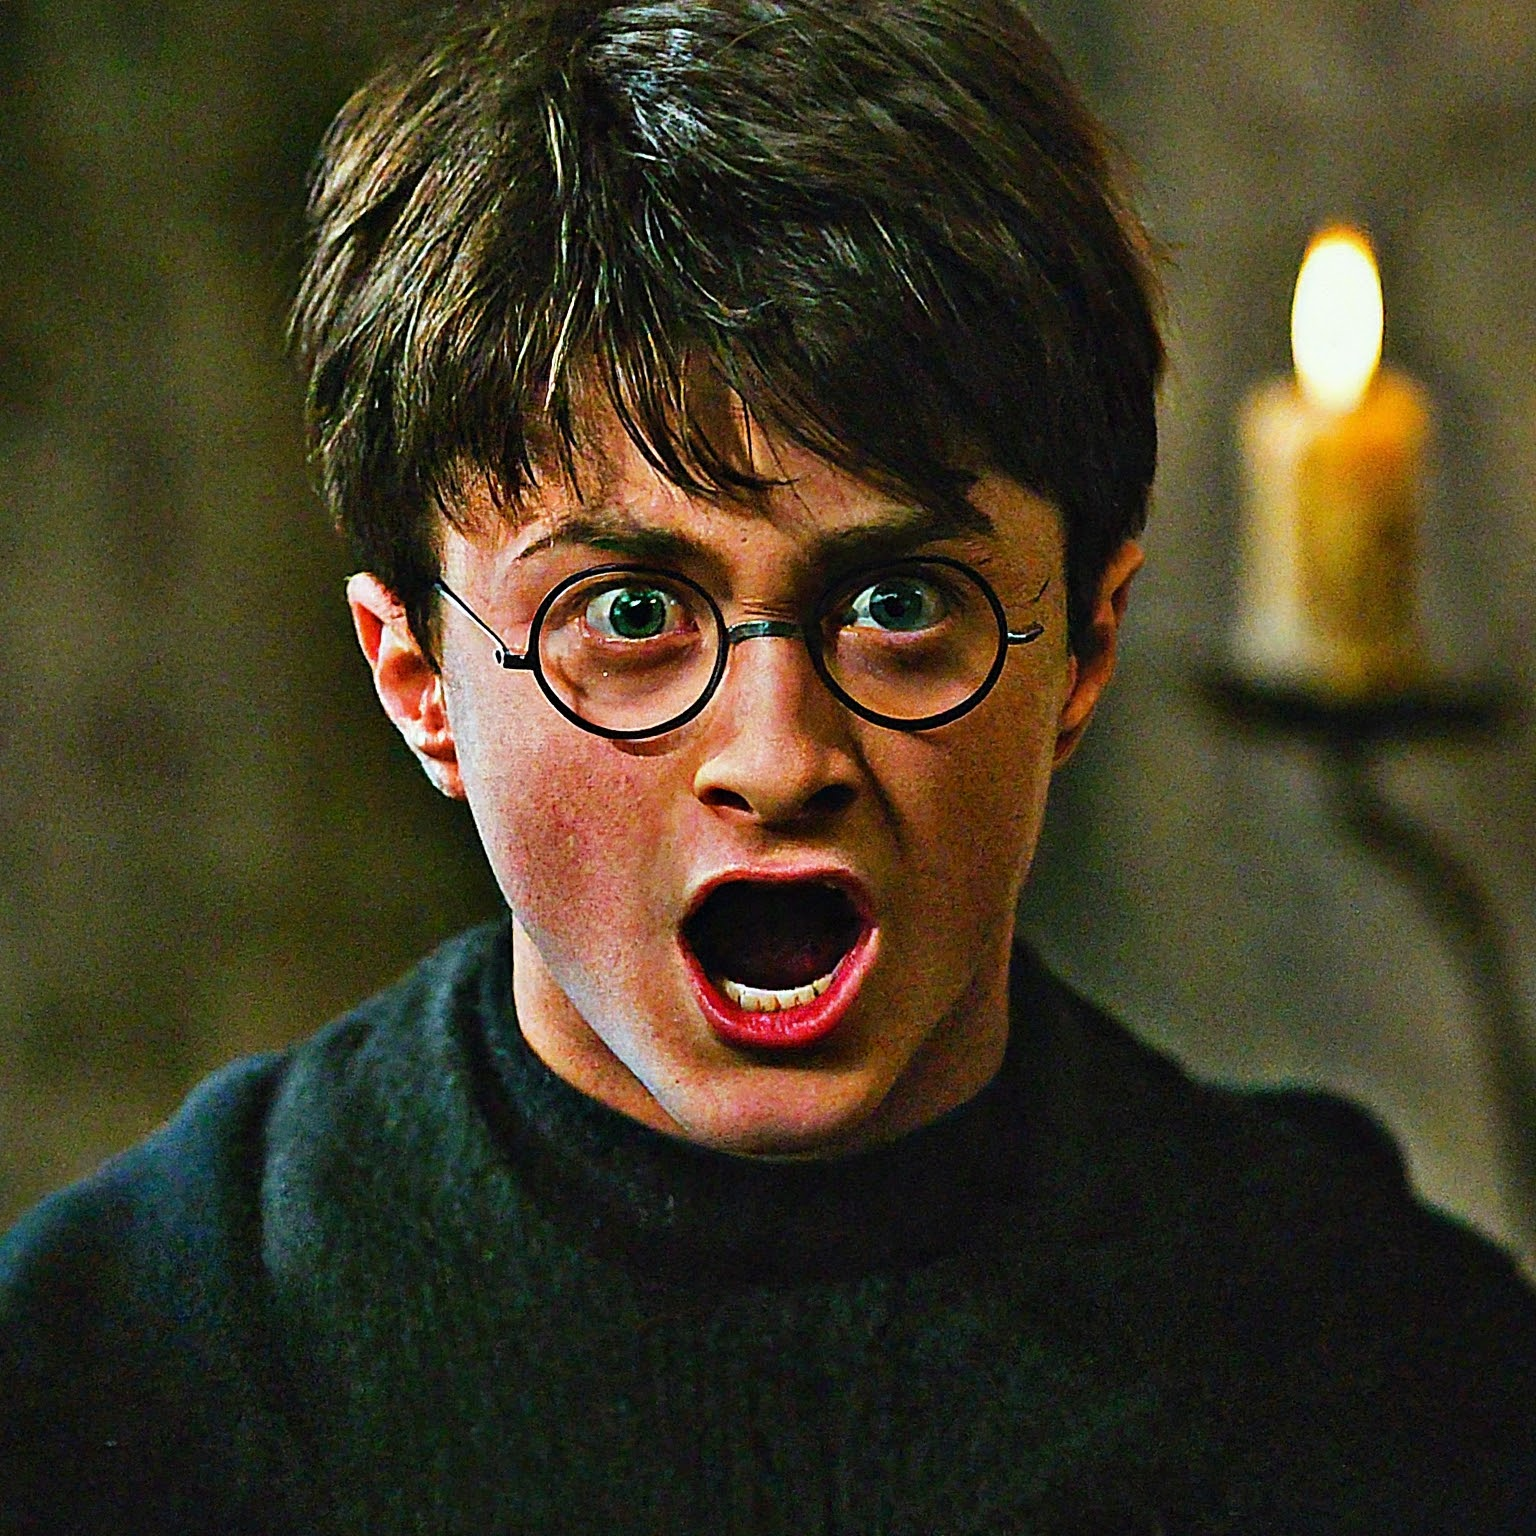

What is the name of the book where the character says "I know that— ” “Mad—Eye wouldn&#39;t want— ” “I KNOW!” Harry bellowed. He felt beleaguered and blackmailed? 
new_topic - Hogwarts Legacy
- Harry Potter Spells
- Magical Creatures
What is the name of the magical creature that is a bird that is the size of a side plate? 


In [ ]:
prev_question = ""
new_topic = ""
LOCATION='global'

for i in range(0,20):

    query = "Generate a question based on the facts from the search "
    
    full_query = query + "  do not generate repeated questions /n \n  but you may choose this topic here :: " + str(new_topic)
    
    question = search_sample(PROJECT_ID, LOCATION, DATASTORE_ID, full_query).summary.summary_text
    print(question)
    
    if prev_question == question :
        input_prompt = " do not generate topic related to this :: -- " + new_topic  + \
        "   give me a two or three word topic about happy potter "
        new_topic = generate_pro(input_prompt)
        print("new_topic", new_topic)
    
    if prev_question != question :
        # input_question = "What is a quote from Harry Potter and the Sorcerer's Stone"
        system_prompt = " Convert this question to a meaning prompt for imagen model to create a good image"

        prompt = question + " " + system_prompt
        image_prompt = generate_pro(prompt)

        
        try:
            # Code that may break
            response = imagen_model.generate_images( prompt=image_prompt,)
            response.images[0].show()
        
        except Exception as e:
            # Handle the exception
            print(f"An error occurred: {e}")
            print("skipping to next question - no image for this")

    prev_question = question